## Import Dependencies

In [2]:
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datasets import load_dataset
from transformers import AutoTokenizer

random.seed(42)
torch.manual_seed(42)

In [3]:
seq_len = 64
n_data = 100000
n_embd = 512
vocab_size = 250027 # mentioned later as len(mbart_tokenizer)
batch_size = 5
n_heads = 8
n_layers = 6
dropout = 0.1
expansion_factor = 4
learning_rate = 1e-4
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Load data

In [4]:
dataset = load_dataset("wmt/wmt14", "de-en")
train = dataset["train"].select(range(n_data))['translation']
test = dataset["test"]['translation']
len(train), len(test)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

(100000, 3003)

## Tokenize data
Section 5.1 of the paper says:
`We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million
sentence pairs. Sentences were encoded using byte-pair encoding [3], which has a shared sourcetarget
vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT
2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece
vocabulary [31]. Sentence pairs were batched together by approximate sequence length. Each training
batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000
target tokens.`
The paper, however, do not focus on implementing the tokenizer, so let us use a pre-trained tokenizer from huggingface that uses byte-pair encoding with share source-target vocabulary of about 250k tokens.

In [5]:
mbart_tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-cc25")
mbart_tokenizer.src_lang = "en_XX"
mbart_tokenizer.tgt_lang = "de_DE"
print(f"Vocab size: {len(mbart_tokenizer)}")
print(f"Source Language: {mbart_tokenizer.src_lang}")
print(f"Target Language: {mbart_tokenizer.tgt_lang}")

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Vocab size: 250027
Source Language: en_XX
Target Language: de_DE


In [6]:
temp_src = train[0]["en"]
temp_tgt = train[0]["de"]
input_tokens = mbart_tokenizer(temp_src, return_tensors="pt", padding=True, truncation=True, max_length=seq_len)
output_tokens = mbart_tokenizer(temp_tgt, return_tensors="pt", padding=True, truncation=True, max_length=seq_len)
input_tokens

{'input_ids': tensor([[   853,  71836,   1363,    111,     70,  56002,      2, 250004]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [7]:
def tokenize_dataset(data, tokenizer):
    german = [x["de"] for x in data] 
    english = [x["en"] for x in data] 

    return tokenizer(
        english,
        text_target=german,
        max_length=seq_len,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

train_tokens = tokenize_dataset(train, mbart_tokenizer)
test_tokens = tokenize_dataset(test, mbart_tokenizer)

In [8]:
train_tokens['input_ids'].shape

torch.Size([100000, 64])

In [9]:
train_tokens['input_ids'][0]

tensor([   853,  71836,   1363,    111,     70,  56002,      2, 250004,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])

In [10]:
train_tokens['labels'][0]

tensor([ 95231, 168704,    122, 192478,      7,  99872,      2, 250003,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])

In [11]:
train_tokens['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Wherever attention_mask is 0, the input_ids and labels corresponding to that are padding labels, the others are what our real text is.

## Token Embedding

If we use all the data at a time, we will run out of RAM in no time. So, let's define a function that returns batches.

In [10]:
def get_batch(data, n_batch, length=n_data):
    random_ids = random.sample(range(0, length), n_batch)
    return {
        'input_ids': data['input_ids'][random_ids],
        'attention_mask': data['attention_mask'][random_ids],
        'labels': data['labels'][random_ids]
    }

In [11]:
sample_batch = get_batch(train_tokens, batch_size)
sample_batch['input_ids'].shape # batch_size, seq_len

torch.Size([5, 64])

In [12]:
class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super(TokenEmbeddings, self).__init__()
        self.embedder = nn.Embedding(vocab_size, n_embd).to(device) # maps vocab_size to n_embd
    def forward(self, x):
        return self.embedder(x.to(device)) 

In [13]:
e = TokenEmbeddings(vocab_size, n_embd)
embs = e(sample_batch['input_ids']) # batch_size * seq_len * n_embd
embs.shape

torch.Size([5, 64, 512])

## Positional Encoding

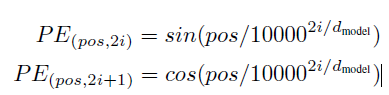

Irrespective of token embeddings, positional encoding is the same to all the embeddings. In the fig., pos corresponds to seq_len dimension and i corresponds to n_embd dimension.

In [14]:
def get_positional_encodings(seq_len, n_embd): 
    x = torch.zeros(seq_len, n_embd) # seq_len * n_embd
    pos = torch.arange(0, seq_len).unsqueeze(1) # seq_len * 1
    i = torch.arange(0, n_embd, 2) # (n_embd/2)
    denominator = torch.pow(10000, -i / n_embd) # (n_embd/2)
    x[:, 0::2] = torch.sin(pos * denominator)
    x[:, 1::2] = torch.cos(pos * denominator) 
    return x.to(device)

In [15]:
pe = get_positional_encodings(seq_len, n_embd).to(device)
pe.shape

torch.Size([64, 512])

## Combine token embeddings and positional encoding
Combining positional encoding will make our model understand the relative positions of words so that they make sense.

In [16]:
inp_embs = embs + pe
inp_embs.shape

torch.Size([5, 64, 512])

## Self Attention
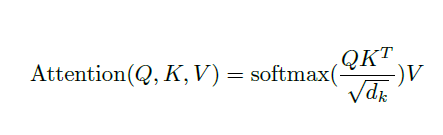

In [17]:
class Attention(nn.Module):
    def __init__(self, n_embd):
        super(Attention, self).__init__()
        self.n_embd = n_embd
        self.q = nn.Linear(n_embd, n_embd)
        self.k = nn.Linear(n_embd, n_embd)
        self.v = nn.Linear(n_embd, n_embd)
    def forward(self, q_encodings, k_encodings, v_encodings, mask=False):
        Q = self.q(q_encodings)
        K = self.k(k_encodings)
        V = self.v(v_encodings)
        sims = torch.matmul(Q, K.transpose(dim0=-2, dim1=-1))
        scaled_sims = sims / torch.sqrt(torch.tensor(self.n_embd, dtype=torch.float32, device=device))
        if mask:
            _, y, z = q_encodings.shape 
            mask_matrix = torch.tril(torch.ones(y, z, device=device))
            mask_matrix = torch.where(mask_matrix == 0, float('-inf'), 0.0)
            scaled_sims = scaled_sims + mask_matrix
        attention_percentages = F.softmax(scaled_sims, dim=-1)
        attention_scores = torch.matmul(attention_percentages, V)
        return attention_scores

## Multihead Attention
The paper states `Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional
output values. These are concatenated and once again projected, resulting in the final values as depicted in Figure 2`.

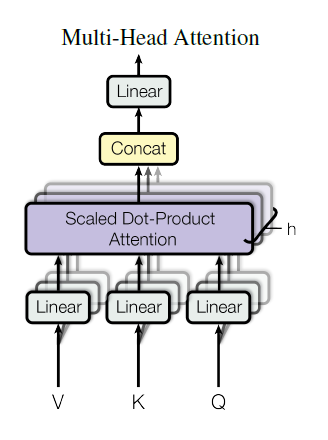

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert n_embd % n_heads == 0, "n_embd i.e, d_model should be divisible by no of Attention heads."
        self.n_embd=n_embd
        self.n_heads=n_heads
        self.head_dim=n_embd//n_heads
        self.heads=nn.ModuleList(
            [Attention(self.head_dim).to(device) for _ in range(n_heads)]
        )
        self.proj=nn.Linear(n_embd, n_embd).to(device)
    def forward(self, q_encodings, k_encodings, v_encodings, mask=False):
        cat=torch.cat([
            head(
                q_encodings[:,:,i * self.head_dim : (i + 1) * self.head_dim], 
                k_encodings[:,:,i * self.head_dim : (i + 1) * self.head_dim], 
                v_encodings[:,:,i * self.head_dim : (i + 1) * self.head_dim],
                mask
            ) for i, head in enumerate(self.heads)], dim=-1)
        mha=self.proj(cat)
        return mha

## Encoder
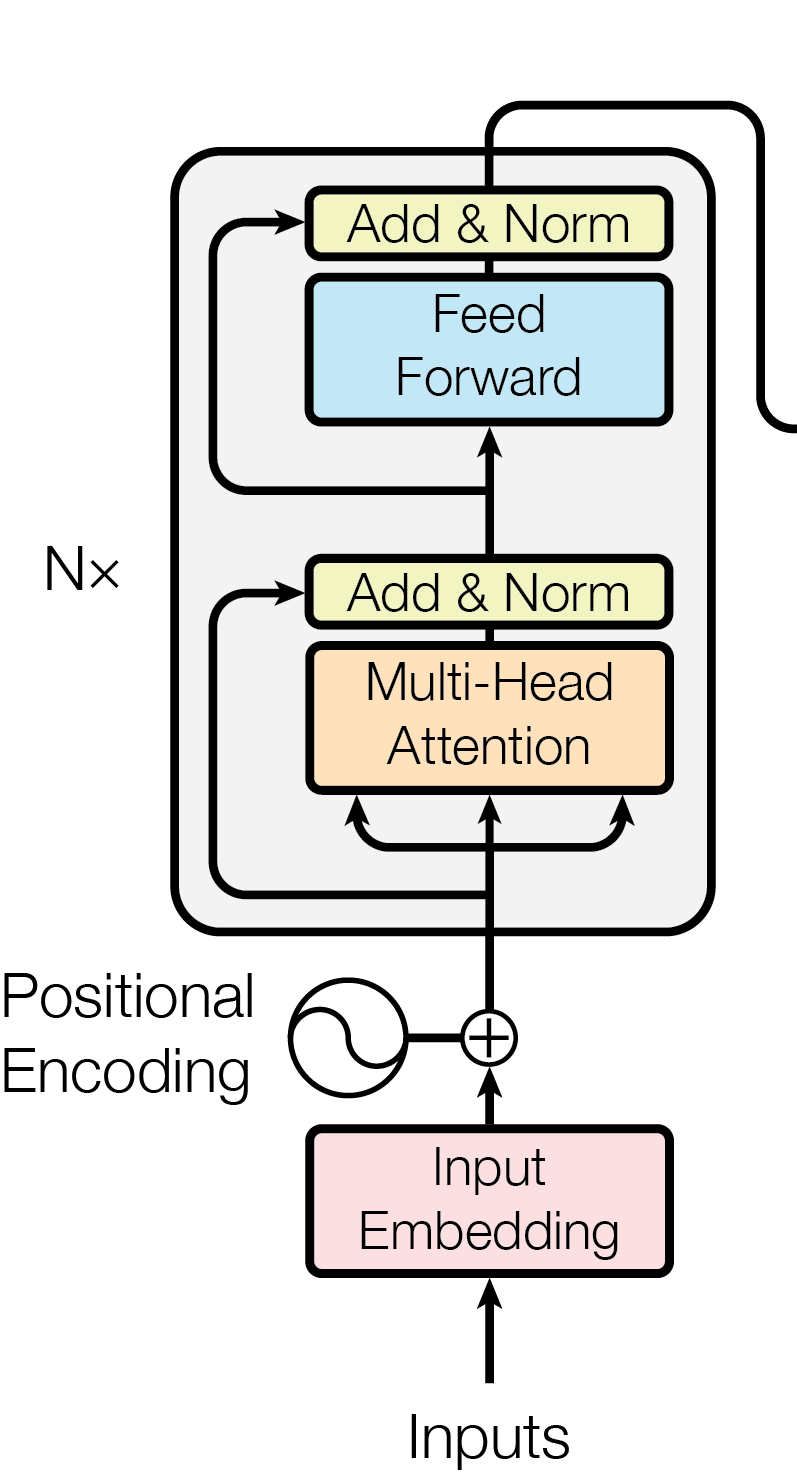

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads, dropout, expansion_factor):
        super(TransformerBlock, self).__init__()
        self.mha=MultiHeadAttention(n_embd, n_heads)
        self.norm1=nn.LayerNorm(n_embd)
        self.norm2=nn.LayerNorm(n_embd)
        self.dropout=nn.Dropout(dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(n_embd, n_embd * expansion_factor, bias=False),
            nn.GELU(),
            nn.Linear(n_embd * expansion_factor, n_embd, bias=False),
        )
    def forward(self, q, k, v):
        att=self.mha(q, k, v)
        out1=self.dropout(self.norm1(q+att))
        ff=self.feedforward(out1)
        out2=self.dropout(self.norm2(out1+ff))
        return out2

In [20]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, n_embd, n_heads, n_layers, seq_len, dropout, expansion_factor):
        super(Encoder, self).__init__()
        self.te=TokenEmbeddings(vocab_size, n_embd)
        self.pe=get_positional_encodings(seq_len, n_embd).to(device)
        self.TransformerStack=nn.ModuleList([
            TransformerBlock(n_embd, n_heads, dropout, expansion_factor) for _ in range(n_layers)
        ])

    def forward(self, batch_data):
        token_embeddings=self.te(batch_data).to(device)
        ip=token_embeddings+self.pe
        for block in self.TransformerStack:
            ip=block(ip, ip, ip)
        return ip

## Decoder

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, n_embd, n_heads, expansion_factor, dropout):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(n_embd)
        self.dropout = nn.Dropout(dropout)
        self.masked_attention = MultiHeadAttention(n_embd=n_embd, n_heads=n_heads)
        self.Transformer = TransformerBlock(
                                n_embd=n_embd,
                                n_heads=n_heads,
                                expansion_factor=expansion_factor,
                                dropout=dropout
                            )
        
    def forward(self, q_enc, k_enc, v_enc, q_dec, k_dec, v_dec, mask=True):
        out1 = self.dropout(self.norm(q_dec + self.masked_attention(q_dec, k_dec, v_dec, mask)))
        out2 = self.dropout(self.norm(out1 + self.Transformer(out1, k_enc, v_enc)))
        return out2


In [22]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, seq_len, n_layers, n_embd, n_heads, expansion_factor, dropout):
        super(Decoder, self).__init__()
        self.te=TokenEmbeddings(vocab_size, n_embd)
        self.pe=get_positional_encodings(seq_len, n_embd)
        self.DecoderStack = nn.ModuleList([
            DecoderBlock(
                n_embd=n_embd,
                n_heads=n_heads,
                expansion_factor=expansion_factor,
                dropout=dropout
            ) for _ in range(n_layers)
        ]) 
        
    def forward(self, decoder_input, encoder_output):
        token_embeddings = self.te(decoder_input)
        ip = token_embeddings + self.pe.to(device)
        for block in self.DecoderStack:
            ip = block(encoder_output, encoder_output, encoder_output, ip, ip, ip)
        return ip

In [23]:
class MachineTranslator(nn.Module):
    def __init__(self, vocab_size, seq_len, n_embd, n_heads, n_layers, expansion_factor, dropout):
        super(MachineTranslator, self).__init__()
        self.encoder = Encoder(
            vocab_size=vocab_size,
            seq_len=seq_len,
            n_embd=n_embd,
            n_heads=n_heads,
            n_layers=n_layers,
            expansion_factor=expansion_factor,
            dropout=dropout
        )
        self.decoder = Decoder(
            vocab_size=vocab_size,
            seq_len=seq_len,
            n_layers=n_layers,
            n_embd=n_embd,
            n_heads=n_heads,
            expansion_factor=expansion_factor,
            dropout=dropout
        )
        self.final_linear = nn.Linear(n_embd, vocab_size)

    def forward(self, encoder_input, decoder_input):
        encoder_output = self.encoder(encoder_input)
        decoder_output = self.decoder(decoder_input, encoder_output)
        output_logits = self.final_linear(decoder_output)
        return output_logits


In [24]:
mt=MachineTranslator(vocab_size, seq_len, n_embd, n_heads, n_layers, expansion_factor, dropout).to(device)
out=mt(sample_batch['input_ids'].to(device), sample_batch['input_ids'].to(device))
out.shape

torch.Size([5, 64, 250027])

## Training

In [26]:
model = MachineTranslator(vocab_size, seq_len, n_embd, n_heads, n_layers, expansion_factor, dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=mbart_tokenizer.pad_token_id)
optimizer = optim.Adam(
    model.parameters(),
      lr=learning_rate,
      betas=(0.9, 0.98),
      eps=1e-9
)
num_batches = 100
print(f"Running the model for a toal of {epochs} epochs with {num_batches} batches each.")
for i in range(epochs):
    epoch_loss = 0
    for batch_i in range(num_batches):
        batch = get_batch(train_tokens, batch_size)
        
        encoder_input = batch['input_ids'].to(device)
        target_ids = batch['labels'].to(device)
        decoder_input = torch.zeros(target_ids.shape)
        # decoder's input is right shift by one token as given in paper, the first token is set as the start token from our tokenizer
        decoder_input[:, 0] = mbart_tokenizer.lang_code_to_id[mbart_tokenizer.tgt_lang]
        decoder_input[:, 1:] = target_ids[:, :-1]
        decoder_input = decoder_input.long()
        
        optimizer.zero_grad()
        logits = model(encoder_input, decoder_input)
        logits = logits.view(-1, logits.size(-1))  
        target_ids = target_ids.view(-1) 
        loss = criterion(logits, target_ids)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        epoch_loss += loss.item()
        if batch_i % 100 == 0:
            print(f"|----Epoch {i}.{batch_i} : Loss of the current batch {loss.item():.4f}")
    print(f"Epoch {i} : Average Loss per Batch {epoch_loss / num_batches:.4f}")

Running the model for a toal of 100 epochs with 100 batches each.
|----Epoch 0.0 : Loss of the current batch 12.6024
Epoch 0 : Average Loss per Batch 9.6316
Running the model for a toal of 100 epochs with 100 batches each.
|----Epoch 1.0 : Loss of the current batch 7.5470
Epoch 1 : Average Loss per Batch 7.1936
Running the model for a toal of 100 epochs with 100 batches each.
|----Epoch 2.0 : Loss of the current batch 6.8998
Epoch 2 : Average Loss per Batch 6.8862
Running the model for a toal of 100 epochs with 100 batches each.
|----Epoch 3.0 : Loss of the current batch 7.0983
Epoch 3 : Average Loss per Batch 6.6623
Running the model for a toal of 100 epochs with 100 batches each.
|----Epoch 4.0 : Loss of the current batch 6.8641
Epoch 4 : Average Loss per Batch 6.5283
Running the model for a toal of 100 epochs with 100 batches each.
|----Epoch 5.0 : Loss of the current batch 6.4594
Epoch 5 : Average Loss per Batch 6.4537
Running the model for a toal of 100 epochs with 100 batches eac

## Save

In [27]:
torch.save(model.state_dict(), "model_weights.pth")

## Load model
I have uploaded the model to Kaggle models so as to fetch it easily even when I restart the session.

In [25]:
model = MachineTranslator(vocab_size, seq_len, n_embd, n_heads, n_layers, expansion_factor, dropout).to(device)
model.load_state_dict(torch.load("../input/attention-is-all-you-need/pytorch/default/1/model_weights.pth"))
model

MachineTranslator(
  (encoder): Encoder(
    (te): TokenEmbeddings(
      (embedder): Embedding(250027, 512)
    )
    (TransformerStack): ModuleList(
      (0-5): 6 x TransformerBlock(
        (mha): MultiHeadAttention(
          (heads): ModuleList(
            (0-7): 8 x Attention(
              (q): Linear(in_features=64, out_features=64, bias=True)
              (k): Linear(in_features=64, out_features=64, bias=True)
              (v): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=False)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bia

## Model Inference

In [96]:
def decode_batch(batch: dict, tokenizer):
    input_ids = batch['input_ids']
    labels = batch['labels']
    attention_mask = batch['attention_mask']
    batch_len = len(input_ids)
    seq_len = len(input_ids[0])
    ans = []
    for i in range(batch_len):
        en = ""
        de = ""
        input_ids_filtered = [ID for ID, mask in zip(input_ids[i], attention_mask[i]) if mask == 1]
        input_ids_filtered = [tok_id for tok_id, mask in zip(input_ids[i], attention_mask[i]) if mask == 1]
        labels_filtered = [label for label in labels[i] if label != 1] 
        
        en += mbart_tokenizer.decode(input_ids_filtered, skip_special_tokens=True)
        de += mbart_tokenizer.decode(labels_filtered, skip_special_tokens=True)
        ans.append({"english": en, "german": de})
    return ans

In [123]:
def generate(model, tokenizer, english_text):
    tokens = tokenizer.encode(
        english_text,
        max_length=seq_len,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    output_logits = model(tokens.to(device), tokens.to(device))
    output = output_logits.argmax(dim=-1)
    return tokenizer.decode(output[0], skip_special_tokens=True)

Inference on one of the train data

In [138]:
batch = get_batch(train_tokens, batch_size, len(train_tokens['input_ids']))
decoded = decode_batch(batch, mbart_tokenizer)
english = decoded[0]["english"]
german = decoded[0]["german"]
translated_german = generate(model, mbart_tokenizer, english)
print("english: ", english)
print("german: ", german)
print("translated_german: ", translated_german)

english:  In this way we will also be able to speed up matters in surrounding rural areas; it is often forgotten that urban and rural problems in fact go hand in hand.
german:  Damit könnten wir auch den sie umgebenden ländlichen Gebieten mehr Entwicklungstempo verleihen. Es wird ja oft vergessen, daß die Probleme der Städte und ländlichen Regionen im Zusammenhang miteinander stehen.
translated_german:  ,,enr, diezuglicht,,,, derne,eßt unden-.ee. der. undieren derungeneee.. ist.....te...............


Inference on one of the test data

In [137]:
batch = get_batch(test_tokens, batch_size, len(test_tokens['input_ids']))
decoded = decode_batch(batch, mbart_tokenizer)
english = decoded[0]["english"]
german = decoded[0]["german"]
translated_german = generate(model, mbart_tokenizer, english)
print("english: ", english)
print("german: ", german)
print("translated_german: ", translated_german)

english:  It is not just horses that can be found and admired on the grounds, but many other animals such as sheep, goats, cows and chickens as well.
german:  Nicht nur Pferde, sondern auch viele weitere Tiere wie Schafe, Ziegen, Kühe und Hühner sind auf dem Gelände anzutreffen und zu bestaunen.
translated_german:  ,ßt,te,,,,glücke,,,,,, und und ich es und unden und, und die wir, daß die und,tenpräsident...ee...e................


## Conclusion

I did not do any evaluation tests, but looking at the inference outputs of several samples from train data and test data, I can say the model is performing better on train data. If trained on a lot more number of steps, there is a lot of scope of improvement. The base model in the paper is trained for 100,000 steps on several GPUs, where as this implementation only trained the model for 100 steps on a single GPU and limited RAM on Kaggle. You can always increase the number of training steps and processing resources and check the results. The main aim of this implementation is to demonstrate the architecture of the Transformer model as proposed in `Attention is all you need` paper.